Import required libraries and set wd.

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm

os.listdir()
#os.chdir('VaR')

['.DS_Store', 'Parametric_&_Historical_VaR.ipynb', 'VaR_data.csv']

# Data Preprocessing & Portfolio Construction

In [109]:
df = pd.read_csv('VaR_data.csv')
df = df.drop(1, axis = 0).reset_index(drop=True)
result = [f"{col}_{df.iloc[0][col]}" for col in df.columns]
df.columns = result
df = df.drop(0, axis = 0).reset_index(drop=True)
for col in list(df.columns)[1:]:
    df[col] = df.loc[:,col].astype(float)
df = df.rename(columns = {df.columns[0]:'Date'})
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Adj Close_AAL,Adj Close.1_DAL,Adj Close.2_UAL,Close_AAL,Close.1_DAL,Close.2_UAL,High_AAL,High.1_DAL,High.2_UAL,Low_AAL,Low.1_DAL,Low.2_UAL,Open_AAL,Open.1_DAL,Open.2_UAL,Volume_AAL,Volume.1_DAL,Volume.2_UAL
0,2024-02-28,15.46,41.560246,44.759998,15.46,42.009998,44.759998,15.58,42.119999,45.130001,15.31,41.500000,44.400002,15.36,41.520000,44.430000,18194600.0,7376400.0,6146200.0
1,2024-02-29,15.68,41.817463,45.490002,15.68,42.270000,45.490002,15.79,42.700001,45.669998,15.45,41.990002,44.930000,15.55,42.169998,45.000000,33255900.0,10294100.0,6997000.0
2,2024-03-01,15.66,41.708645,44.840000,15.66,42.160000,44.840000,15.70,42.330002,45.730000,15.37,41.529999,44.380001,15.70,42.200001,45.610001,25740800.0,5331100.0,7286700.0
3,2024-03-04,14.81,41.124962,44.139999,14.81,41.570000,44.139999,16.15,42.459999,45.180000,14.81,41.209999,43.630001,15.70,41.889999,44.590000,65053000.0,8206500.0,10628800.0
4,2024-03-05,14.67,41.352493,43.740002,14.67,41.799999,43.740002,14.77,41.869999,44.029999,14.29,41.169998,43.410000,14.75,41.250000,43.730000,43648000.0,7123200.0,6078300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2025-02-21,15.23,59.854134,95.889999,15.23,60.000000,95.889999,16.07,64.309998,103.879997,15.09,59.619999,95.360001,15.93,63.950001,103.000000,55698700.0,12798800.0,10968400.0
247,2025-02-24,15.31,61.340515,97.769997,15.31,61.490002,97.769997,15.52,62.290001,99.050003,15.21,60.240002,94.889999,15.38,61.330002,98.339996,42730700.0,11226700.0,6555700.0
248,2025-02-25,15.13,61.639782,96.580002,15.13,61.790001,96.580002,15.37,62.220001,98.320000,14.80,59.820000,93.750000,15.37,61.549999,97.949997,48363100.0,9713100.0,7572100.0
249,2025-02-26,15.18,61.550003,97.400002,15.18,61.700001,97.400002,15.66,63.439999,99.989998,15.17,61.630001,96.919998,15.47,62.200001,98.410004,43181100.0,5474300.0,4763000.0


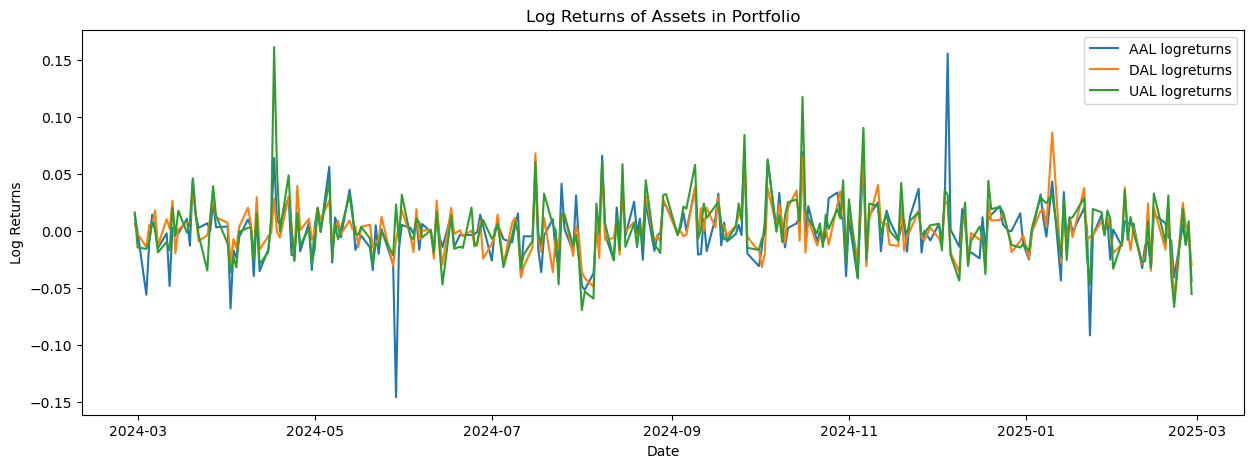

In [110]:
# Extract necessary columns from data
working_df = df.copy().loc[:,['Date','Adj Close_AAL','Adj Close.1_DAL','Adj Close.2_UAL']].rename(columns = {'Adj Close_AAL':'Adj Close AAL','Adj Close.1_DAL':'Adj Close DAL','Adj Close.2_UAL':'Adj Close UAL'})

# Calculate log returns per ticker
adjclose_cols = list(working_df.columns)[-3:]
for col, ticker in zip(adjclose_cols, ['AAL', 'DAL', 'UAL']):
    working_df[f'{ticker} logreturns'] = np.log(working_df[col]/working_df[col].shift(1))

#Visualize returns
return_cols = list(working_df.columns)[-3:]
plt.figure(figsize=(15,5))
for col in return_cols:
    plt.plot(working_df['Date'], working_df[col], label = col)
plt.legend()
plt.title('Log Returns of Assets in Portfolio')
plt.xlabel('Date')
plt.ylabel('Log Returns');


Assume $\Delta P_t $ follows $N(0,\sigma_P^2)$ 

Using the approximation we can simply calculate $\Delta P_t $ as $\Delta P_t \approx \sum_{i=1}^{n} k_i S_i(t)r_i $ where $r_i $ are the log returns of the respective asset $S_i$.

In [111]:
# Portfolio
mil = 10**6
portfolio_dict = {'AAL': int(3.5*mil), 'DAL': int(2.5*mil), 'UAL': int(1.5*mil)}

k1 = portfolio_dict['AAL']
k2 = portfolio_dict['DAL']
k3 = portfolio_dict['UAL']

# Change in Portfolio Value
Delta_P = [np.nan]
for t in range(1,working_df.shape[0]):
    S1, r1 = working_df.loc[t,'Adj Close AAL'], working_df.loc[t,'AAL logreturns'] #AAL
    p1 = k1 * S1 * r1

    S2, r2 = working_df.loc[t,'Adj Close DAL'], working_df.loc[t,'DAL logreturns'] #DAL
    p2 = k2 * S2 * r2

    S3, r3 = working_df.loc[t,'Adj Close UAL'], working_df.loc[t,'UAL logreturns'] #UAL
    p3 = k3 * S3 * r3

    DPt = p1 + p2 + p3
    Delta_P.append(DPt)

working_df['DP Approx'] = Delta_P

# Approx PnL - log returns method
initial_portfolio_value = working_df.loc[0,'Adj Close AAL'] * portfolio_dict['AAL'] + working_df.loc[0,'Adj Close DAL'] * portfolio_dict['DAL'] + working_df.loc[0,'Adj Close UAL'] * portfolio_dict['UAL']
PnL = [initial_portfolio_value]
for t in range(1, working_df.shape[0]):
    x = PnL[t-1] + working_df.loc[t, 'DP Approx']
    PnL.append(x)
working_df['Approx PnL'] = PnL

# Exact PnL
v = working_df.iloc[0,1]*portfolio_dict['AAL'] + working_df.iloc[0,2]*portfolio_dict['DAL'] + working_df.iloc[0,3]*portfolio_dict['UAL']
actual_PnL = [v]
for t in range(1,working_df.shape[0]):
    a = actual_PnL[-1] + (working_df.iloc[t,1] - working_df.iloc[t-1,1])*portfolio_dict['AAL']
    b = (working_df.iloc[t,2] - working_df.iloc[t-1,2])*portfolio_dict['DAL']
    c = (working_df.iloc[t,3] - working_df.iloc[t-1,3])*portfolio_dict['UAL']
    x = a + b + c
    actual_PnL.append(x)
working_df['Actual PnL'] = actual_PnL

# Exact Returns
port_returns = [np.nan]
DP_exact = [np.nan]
for i in range(working_df.shape[0]-1):
    numerator = working_df.loc[i+1,'Actual PnL'] - working_df.loc[i,'Actual PnL']
    r = numerator / working_df.loc[i,'Actual PnL']
    DP_exact.append(numerator)
    port_returns.append(r)
working_df['DP Exact'] = DP_exact
working_df['Portfolio Returns'] = port_returns

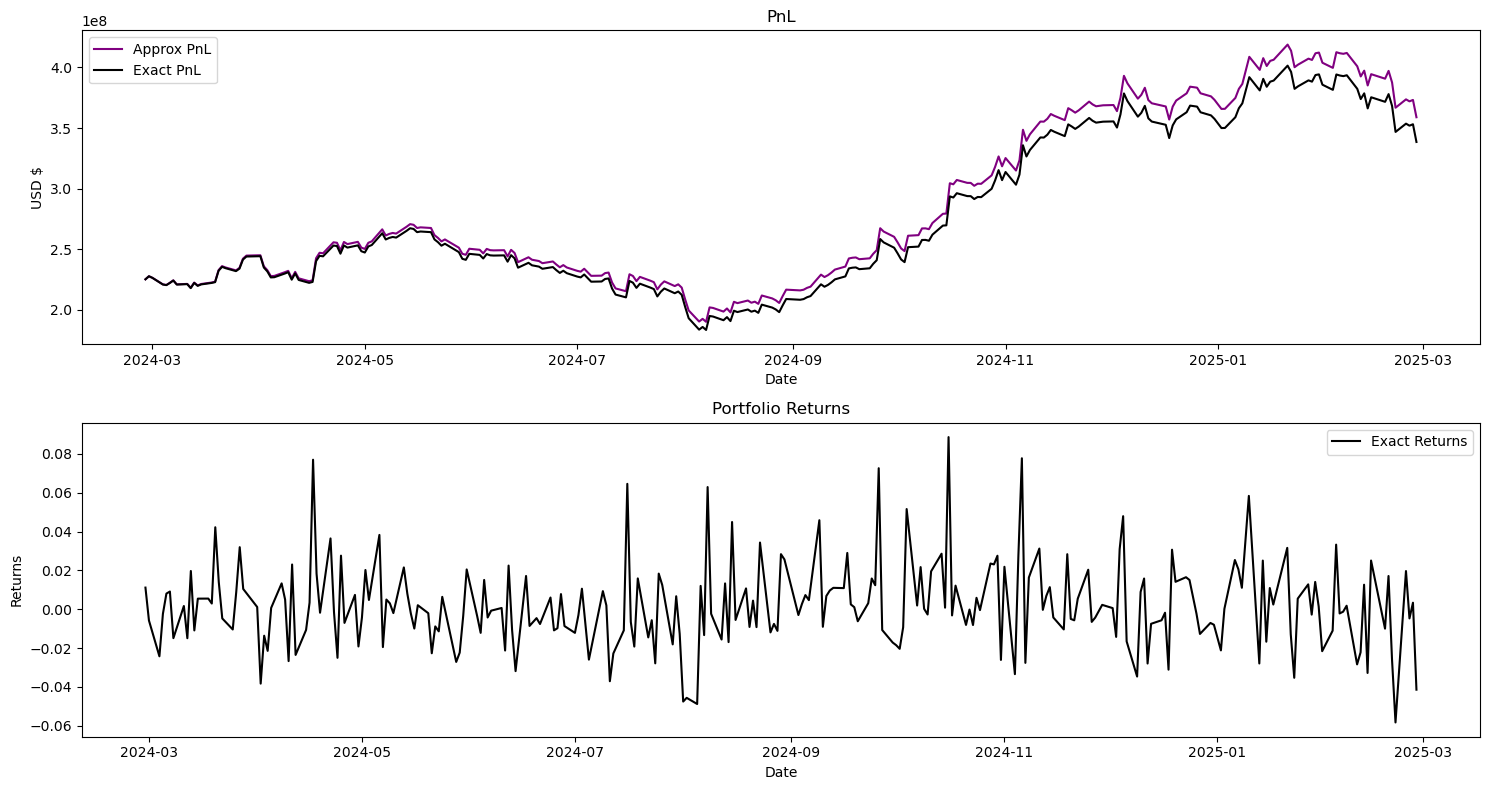

In [112]:
fig, ax = plt.subplots(2, 1, figsize=(15, 8))

ax[0].plot(working_df['Date'],working_df['Approx PnL'], color = 'purple', label = 'Approx PnL')
ax[0].plot(working_df['Date'], working_df['Actual PnL'], color = 'black', label = 'Exact PnL')
ax[0].set_title('PnL')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('USD $');
ax[0].legend()

ax[1].plot(working_df['Date'],working_df['Portfolio Returns'], color = 'black', label = r'Exact Returns', alpha = 1)
ax[1].set_ylabel('Returns')
ax[1].set_title('Portfolio Returns')
ax[1].set_xlabel('Date')
ax[1].legend();

plt.tight_layout()
plt.show()

# Parametric VaR Calculation

Parametric VaR Calculation - using EWM.  

$ VaR = Z_\alpha * \sigma_{\text{portfolio}} * (\text{Portfolio Value}) $

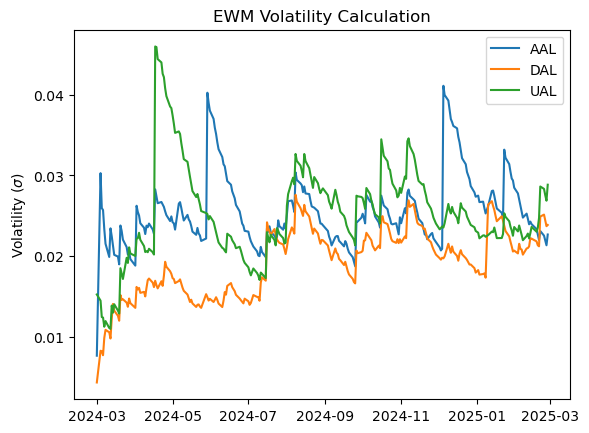

In [113]:
# EWM standard deviation for each asset
alpha = 0.06  # Smoothing parameter
working_df['AAL_EWM'] = working_df['AAL logreturns'].ewm(alpha=alpha, min_periods=1, adjust=True).std(bias=True)
working_df['DAL_EWM'] = working_df['DAL logreturns'].ewm(alpha=alpha, min_periods=1, adjust=True).std(bias=True)
working_df['UAL_EWM'] = working_df['UAL logreturns'].ewm(alpha=alpha, min_periods=1, adjust=True).std(bias=True)

working_df2 = working_df.copy().iloc[2:,:]
for col in ['AAL_EWM','DAL_EWM', 'UAL_EWM']:
    plt.plot(working_df2['Date'], working_df2[col], label = col[:-4])
plt.legend()
plt.title('EWM Volatility Calculation')
plt.ylabel(r'Volatility ($\sigma$)');

In [114]:
# Assign variable as current portfolio market value and weights
recent_portfolio_value = working_df.iloc[-1,-6] #last row ; 3rd last column
recent_AAL_value = working_df.iloc[-1,1] * portfolio_dict['AAL']
recent_DAL_value = working_df.iloc[-1,2] * portfolio_dict['DAL']
recent_UAL_value = working_df.iloc[-1,3] * portfolio_dict['UAL']

market_values = [recent_AAL_value, recent_DAL_value, recent_UAL_value]
weights = {ticker: market_values[index]/recent_portfolio_value for index, ticker in enumerate(['AAL','DAL','UAL'])}
print(weights)

{'AAL': 0.15024299339253172, 'DAL': 0.44130464163706834, 'UAL': 0.40845236497039994}


In [115]:
weights_val = list(weights.values())
returns_df = working_df[['AAL logreturns', 'DAL logreturns', 'UAL logreturns']].dropna()

# EWM covariance matrix
cov_matrix = returns_df.ewm(alpha=alpha).cov(pairwise=True).iloc[-3:].unstack().values.reshape(3, 3)

# Calculate EWM-adjusted portfolio standard deviation
portfolio_std = np.sqrt(weights_val @ cov_matrix @ weights_val)

# Calculate one-day VaR
tao_ = 0.99 # 99% Confidence Level
z_score = norm.ppf(tao_)
one_day_var = z_score * portfolio_std * recent_portfolio_value

In [116]:
print(f"Market Values: {[round(market_values[i],2) for i in range(len(market_values))]}\n")
print(f"Total Portfolio Value: ${recent_portfolio_value:.2f}\n")
print(f"Asset Weights: {weights}\n")
print("EWM Covariance Matrix:\n", cov_matrix)
print(f"\nEWM Portfolio Standard Deviation: {portfolio_std:.6f}\n")
print(f"One-Day VaR at {int(tao_*100)}% confidence (EWM-adjusted): ${one_day_var:,.2f}")

Market Values: [50854999.07, 149375000.0, 138254997.25]

Total Portfolio Value: $338484996.32

Asset Weights: {'AAL': 0.15024299339253172, 'DAL': 0.44130464163706834, 'UAL': 0.40845236497039994}

EWM Covariance Matrix:
 [[0.00053159 0.00036622 0.00050122]
 [0.00036622 0.00058832 0.00061074]
 [0.00050122 0.00061074 0.00085935]]

EWM Portfolio Standard Deviation: 0.024499

One-Day VaR at 99% confidence (EWM-adjusted): $19,291,271.70


# Historical VaR Calculation

Market Values: [50854999.06539917, 149375000.0, 138254997.25341797]

Total Portfolio Value: $338,484,996.32

Asset Weights: {'AAL': 0.15024299339253172, 'DAL': 0.44130464163706834, 'UAL': 0.40845236497039994}

Historical VaR at 99.0% confidence: $15,765,485.14




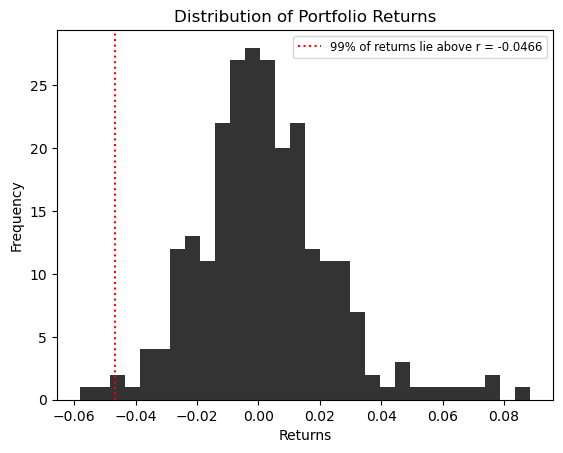

In [117]:
portfolio_returns = working_df['Portfolio Returns'].dropna()

# Compute Historical VaR at 99% confidence level
tao = 0.99
var_threshold = abs(np.percentile(portfolio_returns, (1 - tao) * 100))
historical_var = var_threshold * recent_portfolio_value

# Print results
print(f"Market Values: {market_values}\n")
print(f"Total Portfolio Value: ${recent_portfolio_value:,.2f}\n")
print(f"Asset Weights: {weights}\n")
print(f"Historical VaR at {tao * 100}% confidence: ${historical_var:,.2f}\n\n")

plt.hist(portfolio_returns, bins=30, color='black', alpha = 0.8);
plt.title('Distribution of Portfolio Returns');
plt.ylabel('Frequency');
plt.xlabel('Returns');
plt.axvline(np.percentile(portfolio_returns, (1 - tao) * 100), color = 'red', linestyle=':', label = f'99% of returns lie above r = {(np.percentile(portfolio_returns, (1 - tao) * 100)):.4f}');
plt.legend(fontsize = 'small');

# Conclusion

Comparing the VaR across Parametric method and Historical method: 

Parametric Method -> One-Day VaR at 99% confidence (EWM-adjusted)

Historical Method -> One-Day VaR at 99.0% confidence

Parametric Method > Historical Method 

Therefore, I would recommend that a Portfolio Manager use the Parametric Method because risk minimization is typically ideal and it is better to report a larger risk than smaller risk rather than report a smaller risk when the risk is actually larger.

In [118]:
working_df

,Date,Adj Close AAL,Adj Close DAL,Adj Close UAL,AAL logreturns,DAL logreturns,UAL logreturns,DP Approx,Approx PnL,Actual PnL,DP Exact,Portfolio Returns,AAL_EWM,DAL_EWM,UAL_EWM
0,2024-02-28,15.46,41.560246,44.759998,NaN,NaN,NaN,NaN,2.251506e+08,2.251506e+08,NaN,NaN,NaN,NaN,NaN
1,2024-02-29,15.68,41.817463,45.490002,0.014130,0.006170,0.016178,2.524369e+06,2.276750e+08,2.276587e+08,2.508049e+06,0.011139,0.000000,0.000000,0.000000
2,2024-03-01,15.66,41.708645,44.840000,-0.001276,-0.002606,-0.014392,-1.309651e+06,2.263653e+08,2.263416e+08,-1.317049e+06,-0.005785,0.007699,0.004386,0.015278
3,2024-03-04,14.81,41.124962,44.139999,-0.055807,-0.014093,-0.015734,-5.383469e+06,2.209819e+08,2.208574e+08,-5.484207e+06,-0.024230,0.030289,0.008312,0.014506
4,2024-03-05,14.67,41.352493,43.740002,-0.009498,0.005517,-0.009103,-5.145483e+05,2.204673e+08,2.203362e+08,-5.211692e+05,-0.002360,0.025965,0.008241,0.012479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,2025-02-21,15.23,59.854134,95.889999,-0.040533,-0.060625,-0.066564,-2.080636e+07,3.667481e+08,3.467753e+08,-2.145721e+07,-0.058271,0.023121,0.024915,0.028634
247,2025-02-24,15.31,61.340515,97.769997,0.005239,0.024530,0.019416,6.889915e+06,3.736380e+08,3.535913e+08,6.815953e+06,0.019655,0.022558,0.025159,0.028345
248,2025-02-25,15.13,61.639782,96.580002,-0.011827,0.004867,-0.012246,-1.650379e+06,3.719876e+08,3.519245e+08,-1.666826e+06,-0.004714,0.021935,0.024470,0.027565
249,2025-02-26,15.18,61.550003,97.400002,0.003299,-0.001458,0.008455,1.186212e+06,3.731738e+08,3.531050e+08,1.180553e+06,0.003355,0.021362,0.023727,0.026882
